In [1]:
import numpy as np
import matplotlib.pyplot as plt

# K-means for image compression; choosing k

An image is a matrix of pixels. Each pixel can be represented as an array of RGB (red, green, blue) values. 

In most pictures, the RGB values in one pixel are likely to be similar to those in the pixels around it. For example, the below picture has a lot of white pixels; even in the cat's fur, the grey and black tend to blend together.

![a cat](https://upload.wikimedia.org/wikipedia/commons/4/4d/Cat_March_2010-1.jpg)

If we can identify the common colors (the common RGB values) in a picture, then we can replace the RGB values for each pixel by just centroid RGB values. This in turn allows us to:
* compress the image - we can use the centroid IDs as the pixel's values, and just store the centroid RGB values in a dictionary
* segment the image into regions by color

To do this, we are going to treat the image itself as a dataset. Each row will correspond to a pixel, and the columns will be the RGB values.

## Let's do k-means on a picture!

In [64]:
# Most of this comes from day 22

# Let's define a distance metric; which one is this??
def distance(a, b):
    subtracted = a-b
    return np.sqrt(np.dot(subtracted.T, subtracted))

# Let's define a function to calculate the distance from each data point to each centroid
def get_distances(item, centroids):
    distances = [distance(item, centroid) for centroid in centroids]
    return distances

# Let's define a function to update cluster assignments given a set of centroids
def update_clusters(data, centroids):
    return [np.argmin(get_distances(item, centroids)) for item in data]

# Let's define a function to update the centroids
def update_centroids(data, clusters):
    with_clusters = np.hstack((data, np.array([clusters]).T))
    indices = np.argsort(with_clusters[:, -1])
    with_clusters_sorted = with_clusters[indices]
    by_cluster = np.array_split(with_clusters_sorted, np.where(np.diff(with_clusters_sorted[:, -1])!=0)[0]+1)
    return np.array([np.mean(cluster[:, :-1], axis=0) for cluster in by_cluster])

# Let's define a function to measure the inertia
def inertia(data, centroids, clusters):
    sum_squares = 0
    for i in range(len(data)):
        sum_squares += distance(data[i], centroids[clusters[i]])**2
    return sum_squares / len(data)

In [65]:
# We have to load the picture
from matplotlib.image import imread

image = imread('data/wikimedia_cat.jpg')
print(image.shape)

(69, 100, 3)


In [75]:
# We have to reshape it
data = image.reshape(image.shape[0]*image.shape[1], 3)
print(data.shape)

(6900, 3)


In [77]:
inertia_by_k = []

for k in range(2, 30, 2):
    print(k)
    centroids = np.array([data[x] for x in np.random.choice(np.arange(len(data)), size=k, replace=False)])
    clusters = update_clusters(data, centroids)
    this_inertia = inertia(data, centroids, clusters)
    last_inertia = this_inertia + 1
    while abs(last_inertia - this_inertia) > 0.01:
        last_inertia = this_inertia
        centroids = update_centroids(data, clusters)
        clusters = update_clusters(data, centroids)
        this_inertia = inertia(data, centroids, clusters)
        print(this_inertia)
    inertia_by_k.append(this_inertia)


2
7947.0045356980345
2042.5939542542628
2038.847506808147
2038.8094442312006
2038.8094442312006
4
2861.0279414868337
611.9298540804762
474.09334373777807
447.53490637173337
440.419197922553
436.8251145235465
435.10002548171593
434.0162038381417
433.1675826503711
432.78423176940646
432.4557052698115
432.31714576726233
432.23447520259236
432.12305744960184
432.06925073076997
432.06069048490093
6
2204.656610331343
544.4607442793659
377.7047699142396
323.2183594564662
302.07509091202627
279.9117783809109
248.98440583807042
234.70983140723277
229.49859642759523
226.52721110010205
224.36883040804986
223.3304314812218
222.85164627739658
222.44428095680837
222.21711858794376
222.14221585460834
222.1054570520151
222.07702816972454
222.07099896120144
8
2251.179325520594
463.0610185108405
324.0043738509978
270.3678714875841
235.96148377951926
205.24298605495298
187.99476333388148
178.71380340651427
173.24127666576118
168.9878943838135
164.84864666088853
162.74353260311847
161.1600151349941
160.03

73.87143665915696
73.81173561098768
73.74541148448795
73.6708823582991
73.63231544542528
73.61239297668641
73.58436872828344
73.5678084003585
73.55965624681207
24
1851.5574017597746
325.377805686945
223.21381363047618
189.26102792013472
166.9749501668532
151.54183093392444
139.58809715244362
128.788075881969
121.59699296679167
116.6760393699768
113.36650685052055
110.37577610889986
108.21791601105639
106.29463283978525
104.59946061828624
102.98407773422494
101.31769538972759
100.03133864060497
98.94186740762784
98.28403048886327
97.81142131738366
97.4208754638033
96.93635911672466
96.46862722996023
96.08046400192583
95.71259348675889
95.24305339024164
95.08076884512867
94.97157446764864
94.81364541438577
94.65462097267599
94.52419302022925
94.25247058645424
94.05387356541507
93.83759138978036
93.56586241744961
93.31451205673565
93.07752395286113
92.87333361721991
92.731474987394
92.5989316088327
92.47832929667148
92.38992986380848
92.34609537094212
92.32131693229981
92.3201201297052
26

[2038.8094442312006, 432.06069048490093, 222.07099896120144, 152.26797152794495, 116.6281612767148, 178.94990104028184, 108.9986219778415, 116.62270625403414, 106.79975497280566, 106.81206870677906, 73.55965624681207, 92.3201201297052, 92.8096147466123, 63.07644356765585]


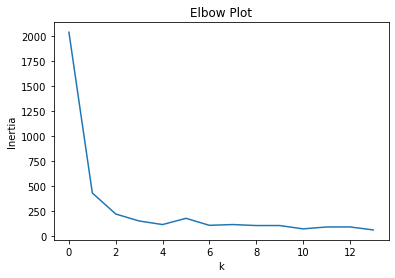

In [78]:
print(inertia_by_k)
fig = plt.figure(figsize=(6,4))
ax1 = fig.add_subplot(111)
ax1.plot(inertia_by_k)
ax1.set_xlabel('k')
ax1.set_ylabel('Inertia')
ax1.set_title('Elbow Plot')
plt.show()

# Question

If you replace each pixel in the above image with an integer (the index of the corresponding centroid), and keep the centroid dictionary, how much smaller is the picture size than the original?

# K-means++

In addition to choosing the distance metric, and choosing $k$, we can change the way we initialize k-means. So far we've tried:
* random - what if it's the wrong random? Try several random initializations, take the best one
* get someone to label a little bit of the data to get an idea - what if the subset they label is not representative?

Now we will look at a third way. It goes like this:
1. Choose a single random data point as the first centroid, $\vec{c_1}$.
2. Repeat til $k$
  1. Calculate the distance between each data point $\vec{x_i}$ and its nearest previously chosen centroid $\vec{c_i}$.
  2. Pick the next centroid according to $p(\vec{x_i}) = \frac{d(\vec{x_i}, \vec{c_i})}{\sum_{j=1}^N d(\vec{x_j}, \vec{c_i})}$. (In python, you can get the index of this next centroid using index = np.random.choice([0, 1, ..., N], p=$p(x_i)$). You can also square the distances in the numerator and denominator above, to spread the distances out further.)

This means that we are more likely to choose a further away data point as the next centroid.


# Resources

* https://github.com/hanyoseob/python-k-means